In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import classifier
import constants
import pathlib
from matplotlib import pyplot as plt
import rcca
import scipy
import mne

In [2]:
# in this experiment, we had fixed target sequence
targets = list(constants.stim.keys())*4

In [6]:
def load_files(folder = './data/RG_video'):
    # load events and data files, return them as numpy arrays
    p = pathlib.Path(folder).resolve()
    events = np.load(list(p.glob('*events*'))[0])[1:]
    data = np.load(list(p.glob('*data*'))[0])
    return data, events

def classify(data, events, window, alg='CCA'):    
    # Classify data with one of the availible algorithms, return naive accuracy
    # See classifier.py for reference.
    res = []
    for event, target in zip(events, targets):
        start = int(np.where(data[:,0] == event)[0])
        end = start+constants.window
        fragment = data[end-window:end,1:]
        result = classifier.classifier_endpoint(fragment, list(set(targets)), window, 1000, voice=False, alg=alg)
        res.append(result==target)
    return sum(res)/len(res)


def plot_ws(data, events, window=2000, alg='CCA'):  
    # Plot the average scalp distribution of CCA coefficients for all target frequencies
    res = []
    ws = []
    ccats = [classifier.create_reference_signals(f=fr, window=window, sampling_rate=1000) for fr in constants.stim.keys()]
    ccats*=4
    for event, target, ccat in zip(events, targets, ccats):
        start = int(np.where(data[:,0] == event)[0])
        end = start+constants.window
        fragment = data[end-window:end,1:]
        
        cca = rcca.CCA(kernelcca = False, reg = 0., numCC = 1, verbose = False)
        cca.train([fragment, ccat])
        ws.append(cca.ws[1].ravel())
    ws = np.array(ws)
    ws = np.average(ws, axis=0)
    
    inf = mne.create_info(ch_names=['P1', 'P2', 'PO3', 'POz', 'PO4', 'O1','Oz', 'O2'], ch_types=['eeg']*8, montage='standard_1005', sfreq=1000, verbose=0)
    mne.viz.plot_topomap(data=ws, pos=inf, extrapolate='local', show_names=True, names=['P1', 'P2', 'PO3', 'POz', 'PO4', 'O1','Oz', 'O2'])

def plot_spectrum(data, events, window=3000):
    # Plot the average power spectrum for all target frequencies
    tg = {a:[] for a in set(targets)}
    for event, target in zip(events, targets):
        start = int(np.where(data[:,0] == event)[0])
        end = start+constants.window
        fragment = data[end-window:end,1:]
        
        tg[target].append([scipy.signal.welch(fragment[:,ch], fs=1000, nperseg=2500, noverlap=20) for ch in range(np.min(fragment.shape))])
    for freq in tg.keys():
        print (freq)
        w = np.array([a for a in tg[freq]])[:,:,1,:]
        w = np.average(w, axis=0)
        w.shape
        l = plt.plot(tg[freq][0][0][0][0:50], w.T[0:50,:])
        plt.legend(iter(l), ['P1', 'P2', 'PO3', 'POz', 'PO4', 'O1','Oz', 'O2'])
        plt.suptitle(freq)
#         plt.legend()
        plt.show()
        


In [1]:
r = range(500, 4000, 100) # create different windows to find optimal performance. We are interested in 0.5 - 4 second windows.
x = [a/1000 for a in r] # Create X axis (seconds) for plotting performance vs window size

Next, let's test all recorded sessions.

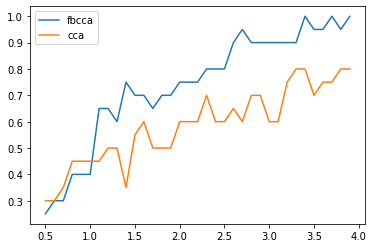

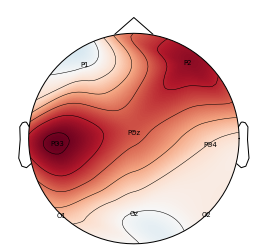

5


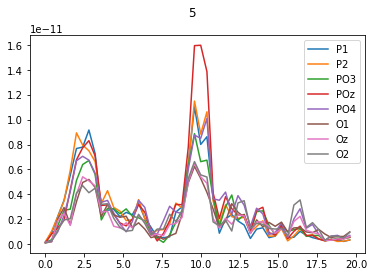

7.5


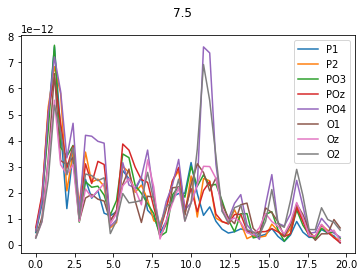

8.57


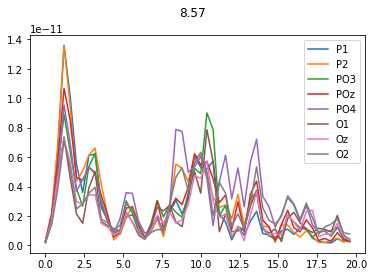

10


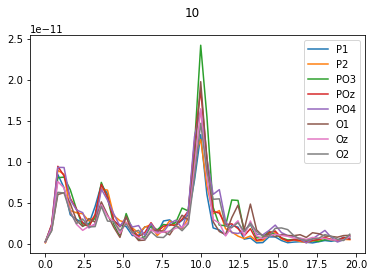

12


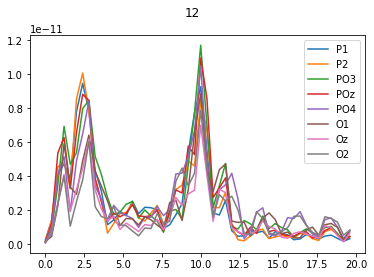

In [11]:
data, events = load_files()
res_F = [classify(data, events, window=a, alg='FBCCA') for a in r]
res_C = [classify(data, events, window=a, alg='CCA') for a in r]
plt.plot(x, res_F, label='fbcca')
plt.plot(x, res_C, label='cca')
plt.legend()
plt.show()
res_F_1 = res_F
plot_ws(data, events)

tg = plot_spectrum(data, events)


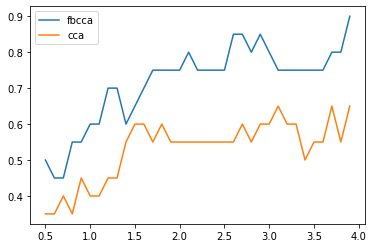

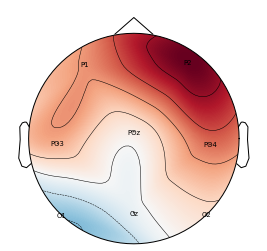

In [22]:
data, events = load_files('./data/BW_video')
res_F = [classify(data, events, window=a, alg='FBCCA') for a in r]
res_C = [classify(data, events, window=a, alg='CCA') for a in r]
res_F_2 = res_F

plt.plot(x, res_F, label='fbcca')
plt.plot(x, res_C, label='cca')
plt.legend()
plt.show()

plot_ws(data, events)

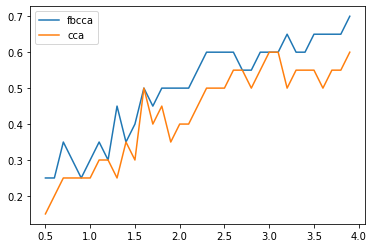

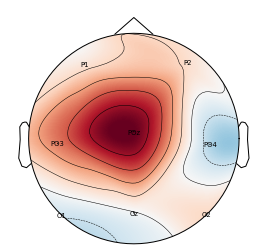

In [23]:
data, events = load_files('./data/BW_black')
res_F = [classify(data, events, window=a, alg='FBCCA') for a in r]
res_C = [classify(data, events, window=a, alg='CCA') for a in r]
res_F_3 = res_F

plt.plot(x, res_F, label='fbcca')
plt.plot(x, res_C, label='cca')
plt.legend()
plt.show()

plot_ws(data, events)

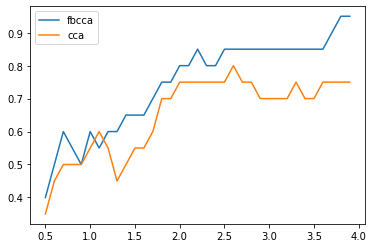

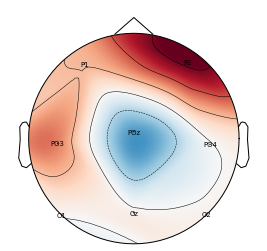

In [24]:
data, events = load_files('./data/RG_black')
res_F = [classify(data, events, window=a, alg='FBCCA') for a in r]
res_C = [classify(data, events, window=a, alg='CCA') for a in r]
res_F4 = res_F

plt.plot(x, res_F, label='fbcca')
plt.plot(x, res_C, label='cca')
plt.legend()
plt.show()

plot_ws(data, events)

Plot the accuracy vs time window graphs for all sesions

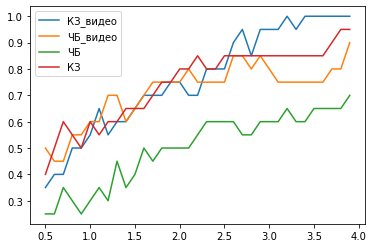

In [33]:
l = plt.plot(x, np.array([res_F_1, res_F_2, res_F_3, res_F4]).T) 
plt.legend(iter(l), ['КЗ_видео', 'ЧБ_видео', 'ЧБ', 'КЗ'])